# Figure 5 Habituation Model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io

from scipy.optimize import curve_fit
import matplotlib as mpl

sns.set_style("ticks")

In [4]:
# Plot formatting

params = {
    "axes.labelsize": 16,
    "font.size": 13,
    "legend.fontsize": 11,
    "legend.frameon": False,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "axes.grid": False,
}
plt.rcParams.update(params)

### PDR JND data

In [6]:
BC1 = np.array([100, 85.3, 61.8, 53.5, 32, 16, 12.96]) / 100
JND1 = np.array([6, 8, 12, 22, 24, 44, 70])

BC2=np.array([100, 85.3, 82.5, 61.8, 53.5, 32, 16, 8.77]) / 100
JND2=np.array([10, 10, 10, 14, 16, 30, 40, 88])

BC3 = np.array([99.4, 85.3, 61.8, 53.5, 34, 16]) / 100
JND3 = np.array([12, 16, 22, 34, 40, 70])

BC4 = np.array([100, 85.3, 70.5, 61.8, 53.5, 34, 16]) / 100
JND4 = np.array([12, 16, 22, 30, 30, 48, 90])

BC5 = np.array([99.4, 85.3, 61.8, 53.5, 34]) / 100
JND5 = np.array([14, 14, 24, 32, 48])

## Functions

In [8]:
def sample_elevation(sample_size):
    parameters = np.array([-23, 12.15, 28.6])

    x = np.linspace(-90, 90, 1001)
    
    dx = np.diff(x)[0]
    
    prior = np.exp(-0.5 * ((x - parameters[0]) / parameters[1])**2)
    prior[x > parameters[0]] = np.exp(-0.5 * ((x[x > parameters[0]] - parameters[0]) / parameters[2])**2)
    
    F = np.cumsum(prior) / np.sum(prior)

    elevation = np.zeros(sample_size)

    for n in range(sample_size):
        elevation[n] = x[np.argmin(np.abs(F - np.random.uniform(0,1)))]

    return np.sort(elevation)

In [9]:
def f(x, f_max, w):
    return f_max * np.exp(-0.5*(x/w)**2)

In [10]:
def get_f_max(bc):
    return 2.04*bc**2 + 2.55*bc + 0.86

In [11]:
def get_tuning_width(w_bc1, bc):
        
    coef = -4
    
    y = np.exp(coef*bc) 

    width_percent = y * 114 / 100

    w = w_bc1*(1 + width_percent)
    
    return w

In [12]:
def get_itd_std(bc):
    sigma_ITD = 0
    return sigma_ITD + 219.34*np.exp(-11.31 * bc) 

In [13]:
def get_neuron_response_bc(bc, best_itd, w_bc1, itds, number_trial):
    

    r = np.zeros(len(itds))
    
    s = np.zeros(len(itds))
    
    f_max = get_f_max(bc)    
    w = get_tuning_width(w_bc1, bc)
    itd_std = get_itd_std(bc)
    ##

    for n, itd in enumerate(itds):
    
        ITD = itd + np.random.normal(loc=0, scale=itd_std, size=number_trial)

        rate = f(ITD-best_itd, f_max, w)
        
        a = np.random.poisson(lam=rate)
        
        r[n] = np.mean(a)
        
        s[n] = np.std(a, ddof=1)

    return r, s

In [14]:
def get_d_pop_bc(bc, best_itd, w_bc1, train_itd, ditd, number_train):

    #f_min = 0
    f_min = 0.1
    
    f_max = get_f_max(bc)    
    w = get_tuning_width(w_bc1, bc)
    itd_std = get_itd_std(bc)
    
    ITD = train_itd + np.random.normal(loc=0, scale=itd_std, size=number_train)
    
    rate = np.array([f(itd-best_itd, f_max, w) for itd in ITD]) + f_min
    
    
    a = np.random.poisson(lam=rate)
    
    a_mean = np.mean(a, axis=0)
    
    a_std = np.std(a, axis=0, ddof=1)
    
    w_denominator = a_std ** 1
    
    a_new = f(train_itd + ditd - best_itd, f_max, w) 

    index = w_denominator > 0

    # z-score version
    d_neuron = np.abs(a_new[index] - a_mean[index]) / w_denominator[index]
    
    d_pop = np.mean(d_neuron)
    
    return d_pop

In [15]:
def get_jnd_from_d_pop(ditds, d_pop, d_threshold):

    return np.interp(d_threshold, d_pop, ditds)

In [16]:
def get_d_pop_bc_rate(bc, best_itd, w_bc1, train_itd, ditd, number_train):


    f_min = 0.1
    
    f_max = get_f_max(1)    
    w = get_tuning_width(w_bc1, bc)
    itd_std = get_itd_std(bc)
    
    ITD = train_itd + np.random.normal(loc=0, scale=itd_std, size=number_train)
    
    rate = np.array([f(itd-best_itd, f_max, w) for itd in ITD]) + f_min
    
    
    a = np.random.poisson(lam=rate)
    
    a_mean = np.mean(a, axis=0)
    
    a_std = np.std(a, axis=0, ddof=1)
    
    w_denominator = a_std ** 1
    
    a_new = f(train_itd + ditd - best_itd, f_max, w) 

    index = w_denominator > 0

    # z-score version
    d_neuron = np.abs(a_new[index] - a_mean[index]) / w_denominator[index]
    
    d_pop = np.mean(d_neuron)
    
    return d_pop

## Figures

In [18]:
np.random.seed(0)

number_neurons = 2_000

# Azimuth and ITD
best_az = np.sort(np.random.normal(0, 23.3, number_neurons))
best_itd = best_az * 2.8

hw_az = 20
w_az = hw_az /(4*np.log(2)) * np.ones(number_neurons)

hw_bc1 = hw_az * 2.8
w_bc1 = hw_bc1 /(4*np.log(2))

# Elevation
best_el = sample_elevation(number_neurons)

hw_el = 41
w_el = hw_el /(4*np.log(2)) * np.ones(number_neurons)

## Bala Azimuth and elevation

In [20]:
train_x = 0

number_train = 100

dxs = np.linspace(1, 15, 101)

d_pop_az = np.zeros(len(dxs))
d_pop_el = np.zeros(len(dxs))

bc = 1

for n, dx in enumerate(dxs):
 
    d_pop_az[n] = get_d_pop_bc(bc, best_az, w_az, train_x, dx, number_train)
    d_pop_el[n] = get_d_pop_bc(bc, best_el, w_el, train_x, dx, number_train)

In [21]:
d = np.linspace(0.2, 1.4, 100)
number_d = len(d)

mse = np.zeros(number_d)

for n, d_threshold in enumerate(d):
    
    jnd_az = get_jnd_from_d_pop(dxs, d_pop_az, d_threshold)
    
    jnd_el = get_jnd_from_d_pop(dxs, d_pop_el, d_threshold)

    mse[n] = 0.5 * ((jnd_az - 3.5)**2 + (jnd_el - 8.4)**2)
    

d_threshold = d[np.argmin(mse)]

jnd_az = get_jnd_from_d_pop(dxs, d_pop_az, d_threshold)
    
jnd_el = get_jnd_from_d_pop(dxs, d_pop_el, d_threshold)

print(d_threshold, jnd_az, jnd_el)

0.6606060606060606 4.678385400386997 7.612515710896265


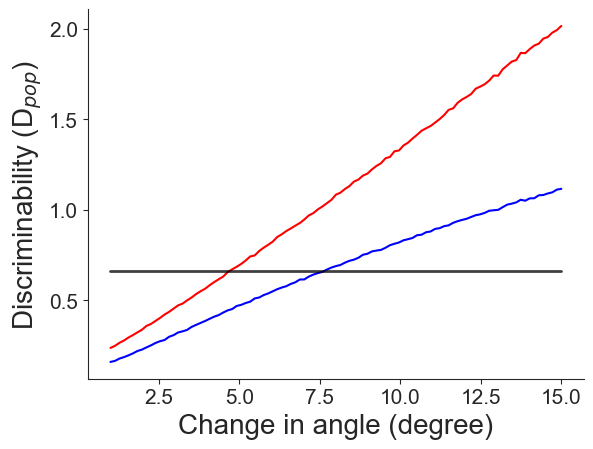

In [22]:
plt.plot(dxs, d_pop_az, '-', color='r')
plt.plot(dxs, d_pop_el, '-', color='b');

plt.plot(dxs, np.ones(len(dxs))*d_threshold, '-', color='k', alpha=0.75, lw=2)


sns.despine(right=True, top=True)

plt.xlabel('Change in angle (degree)', fontsize=20)
plt.ylabel('Discriminability (D$_{pop}$)', fontsize=20)

plt.show()

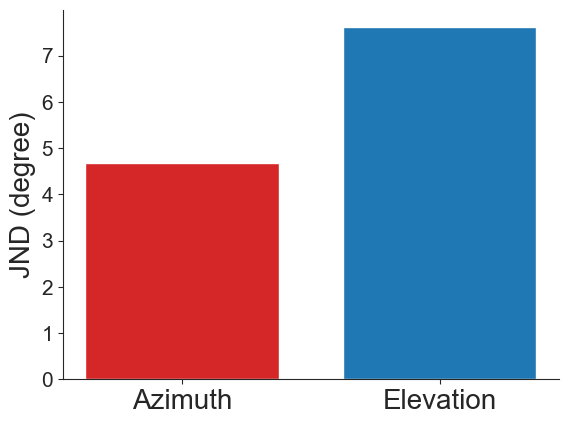

In [23]:
plt.bar([0, 1], [jnd_az, jnd_el], color=['tab:red', 'tab:blue'], width=0.75)

plt.xticks([0, 1], ['Azimuth', 'Elevation'], fontsize=20)

sns.despine(right=True, top=True)

plt.ylabel('JND (degree)', fontsize=20)

plt.show()

## BC simulation

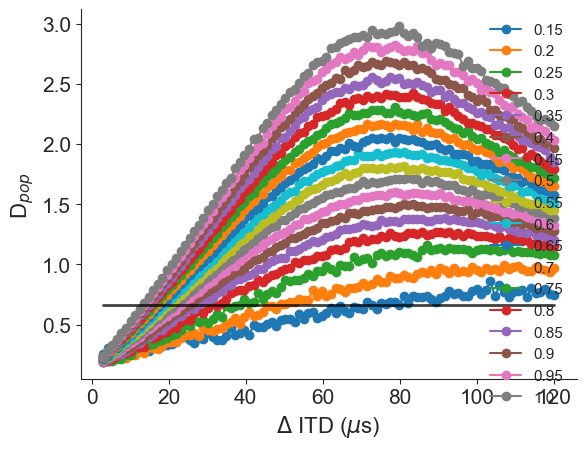

In [25]:
np.random.seed(1)

# Initialize
train_itd = 0
number_train = 100


BC = np.arange(0.15, 1.05, .05)
ditds = np.linspace(3, 120, 100)

d_pop = np.zeros((len(BC), len(ditds)))


# Run the simulation
plt.figure()
for k, bc in enumerate(BC):

    for n, ditd in enumerate(ditds):
 
        d_pop[k, n] = get_d_pop_bc(bc, best_itd, w_bc1, train_itd, ditd, number_train)
        
    plt.plot(ditds, d_pop[k], '-o')

plt.legend(BC.round(2))

plt.plot(ditds, np.ones(len(ditds))*d_threshold, '-', color='k', alpha=0.75, lw=2)


plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
sns.despine(right=True, top=True)

plt.xlabel('$\Delta$ ITD ($\mu$s)')
plt.ylabel('D$_{pop}$ ')

plt.show()

In [26]:
jnd_model = np.zeros(len(BC))

for k in range(len(BC)):

    jnd_model[k] = get_jnd_from_d_pop(ditds, d_pop[k], d_threshold)

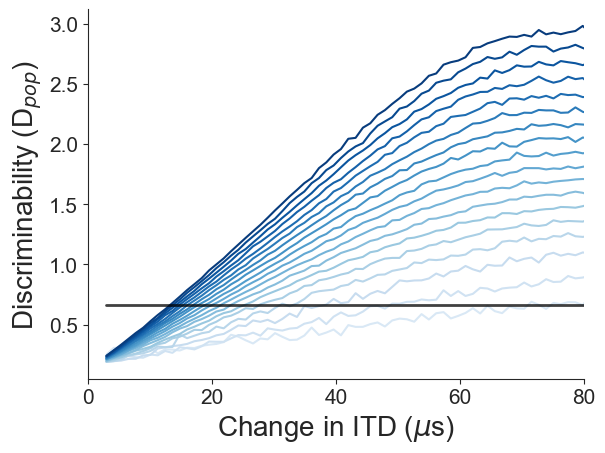

In [27]:
cmap = mpl.colormaps['Blues']
colors = cmap(np.linspace(0.15, 0.95, len(BC)))


plt.figure()
for k, bc in enumerate(BC):
    plt.plot(ditds, d_pop[k], '-', color=colors[k]);

plt.plot(ditds, np.ones(len(ditds))*d_threshold, '-', color='k', alpha=0.75, lw=2)


plt.xlim(0, 80)


sns.despine(right=True, top=True)

plt.xlabel('Change in ITD ($\mu$s)', fontsize=20)
plt.ylabel('Discriminability (D$_{pop}$)', fontsize=20)

plt.show()

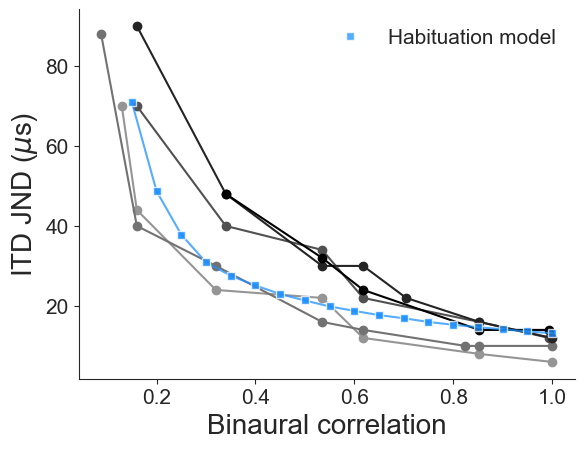

In [28]:
jnd_data = dict({'data1':zip(BC1, JND1),
                 'data2':zip(BC2, JND2),
                 'data3':zip(BC3, JND3),
                 'data4':zip(BC4, JND4),
                 'data5':zip(BC5, JND5)})

cmap = mpl.colormaps['Greys']
colors = cmap(np.linspace(0.5,1,5))

plt.figure()

plt.plot(BC, jnd_model, 's', color='dodgerblue', alpha=0.75, mec='w')


for n in range(5):
    bc, jnd = zip(*jnd_data['data'+str(n+1)])
    
    plt.plot(bc, jnd , 'o-', color=colors[n])

plt.plot(BC, jnd_model, 's-', color='dodgerblue', alpha=0.75, mec='w')


sns.despine(right=True, top=True)

plt.xlabel('Binaural correlation', fontsize=20)
plt.ylabel('ITD JND ($\mu$s)', fontsize=20)

plt.legend(['Habituation model'], frameon=False, fontsize=15)

plt.show()

### Keep the rate constant

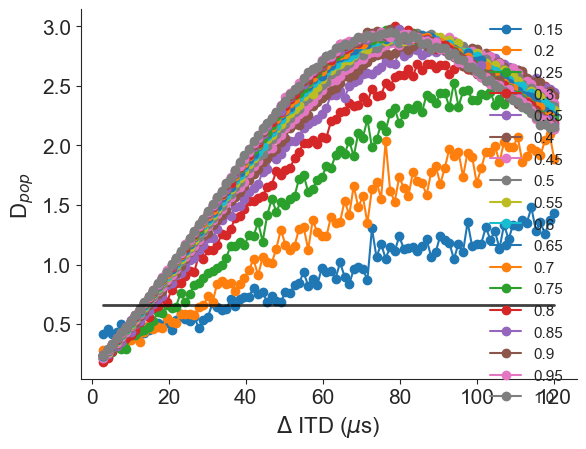

In [30]:
# Initialize
train_itd = 0
number_train = 100


BC = np.arange(0.15, 1.05, .05)
ditds = np.linspace(3, 120, 100)

d_pop_rate = np.zeros((len(BC), len(ditds)))


# Run the simulation
plt.figure()
for k, bc in enumerate(BC):

    for n, ditd in enumerate(ditds):
 
        d_pop_rate[k, n] = get_d_pop_bc_rate(bc, best_itd, w_bc1, train_itd, ditd, number_train)

    plt.plot(ditds, d_pop_rate[k], '-o')

plt.legend(BC.round(2))

plt.plot(ditds, np.ones(len(ditds))*d_threshold, '-', color='k', alpha=0.75, lw=2)


sns.despine(right=True, top=True)

plt.xlabel('$\Delta$ ITD ($\mu$s)')
plt.ylabel('D$_{pop}$ ')

plt.show()

In [31]:
jnd_model_rate = np.zeros(len(BC))

for k in range(len(BC)):

    jnd_model_rate[k] = get_jnd_from_d_pop(ditds, d_pop_rate[k], d_threshold)


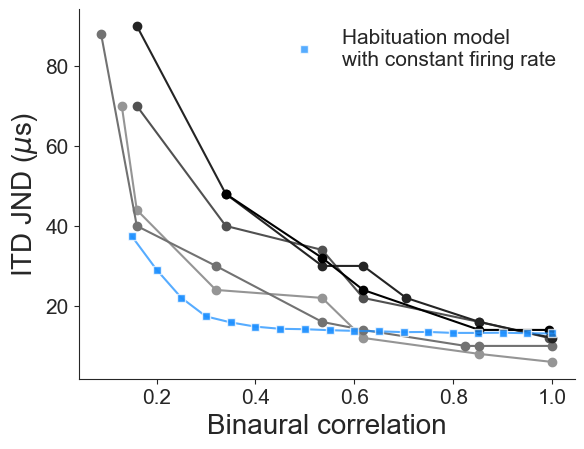

In [32]:
jnd_data = dict({'data1':zip(BC1, JND1),
                 'data2':zip(BC2, JND2),
                 'data3':zip(BC3, JND3),
                 'data4':zip(BC4, JND4),
                 'data5':zip(BC5, JND5)})

cmap = mpl.colormaps['Greys']
colors = cmap(np.linspace(0.5,1,5))

plt.figure()

plt.plot(BC, jnd_model_rate, 's', color='dodgerblue', alpha=0.75, mec='w')

for n in range(5):
    bc, jnd = zip(*jnd_data['data'+str(n+1)])
    
    plt.plot(bc, jnd , 'o-', color=colors[n])

plt.plot(BC, jnd_model_rate, 's-', color='dodgerblue', alpha=0.75, mec='w')
 

sns.despine(right=True, top=True)

plt.xlabel('Binaural correlation', fontsize=20)
plt.ylabel('ITD JND ($\mu$s)', fontsize=20)

plt.legend(['Habituation model \nwith constant firing rate'], frameon=False, fontsize=15)

plt.show()

## Example responses

In [34]:
def get_itd_curve(unit_number, bc, df):

    itd = df.loc[(df['unit_number']==unit_number) & (df['bc']==bc), 'itd'].squeeze()
    ITD = np.fromstring(itd[1:-1], sep=',')

    mean_count = df.loc[(df['unit_number']==unit_number) & (df['bc']==bc), 'mean_spike_count'].squeeze()
    mean_spike_count = np.fromstring(mean_count[1:-1], sep=',')

    std_count = df.loc[(df['unit_number']==unit_number) & (df['bc']==bc), 'std_spike_count'].squeeze()
    std_spike_count = np.fromstring(std_count[1:-1], sep=',')

    return ITD, mean_spike_count, std_spike_count

In [35]:
def gaussian(x, mu, sigma, min_response, dynamic_range):
    
    """ This function models ILD tuning curves with a Gaussian function with 
    variable min and max
    
    Parameters
    mu = mean of the Gaussian
    sigma = standard deviation of the Gaussian
    min_response = minimum response
    dynamic_range = max response - min_response
    
    """
    r = dynamic_range * np.exp(-.5*((x - mu)/sigma)**2) + min_response
    
    return r

In [36]:
def fit_gaussian(ITD, mean_spike_count, bounds=([-300, 0.0, 0.0, 0.0], [300, 150.0, 20.0, 50.0])):
    
    x = ITD
    y = mean_spike_count
    
    x_spline = np.linspace(np.min(x), np.max(x), 1001, endpoint=True)
    y_spline = np.interp(x_spline, x, y)
    
    
    # Initialize guesses for parameters (best ITD, sigma, min response, dynamic range)
    parameter_initial_guess = [x[np.argmax(y)], bounds[0][1]+5, np.min(y), np.max(y)*.95]
    
    # Do the fitting
    best_parameters, _ = curve_fit(gaussian, 
                                   xdata=x_spline, ydata=y_spline, 
                                   p0=parameter_initial_guess, 
                                   maxfev=50_000,
                                   bounds=bounds
                                  )
    return best_parameters 

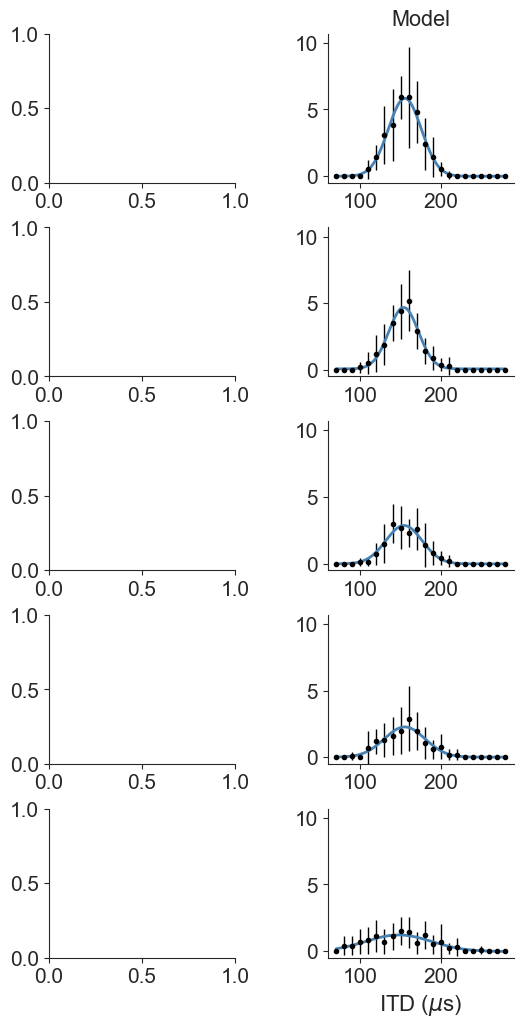

In [40]:
np.random.seed(4)

plt.subplots(5,2, figsize=(6,12))

   


ITD = np.arange(70, 290, 10)
number_trial = 10
best_itd = 155

BC = np.arange(100, 0, -20) / 100
number_bc = len(BC)

min_width = 20

for n, bc in enumerate(BC):

    # Get the ITD curve for this neuron and BC
    mean_spike_count, std_spike_count = get_neuron_response_bc(bc, best_itd, w_bc1, ITD, number_trial)

    # Set the bounds and fit
    bounds=([ITD.min()-10, min_width, -0.1, -0.1], [ITD.max()+10, 250.0, np.max(mean_spike_count)*1.1, np.max(mean_spike_count)*1.25])

    best_parameters = fit_gaussian(ITD, mean_spike_count, bounds)
    
    # Reset the bound for gaussian sd
    min_width = 0.8*best_parameters[1]

    plt.subplot(5, 2, 2*(n+1))
    # Plot data
    plt.errorbar(ITD, mean_spike_count, std_spike_count, fmt='o', ecolor='k', color='k', elinewidth=1, ms=3)
    
    # Plot gaussian fit
    x = np.linspace(np.min(ITD), np.max(ITD), 1001, endpoint=True)
    model_curve = gaussian(x, *best_parameters) 
    plt.plot(x, model_curve, label='model', color='steelblue', lw=2)
    
    # Style
    if n == 0:
        y_max = np.max(mean_spike_count+std_spike_count)*1.1
        plt.title('Model')
    plt.ylim(-.5, y_max)
        
    
    if n == number_bc-1:
        plt.xlabel('ITD ($\mu$s)')

    sns.despine(right=True, top=True)




plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

plt.show()


## Model tuning

In [42]:
np.random.seed(100)

x = np.arange(-70, 70, 5)
number_trial = 100
best_x = 0

bc = 1


r_az, s_az = get_neuron_response_bc(bc, best_x, w_az[0], x, number_trial)

r_el, s_el = get_neuron_response_bc(bc, best_x, w_el[0], x, number_trial)


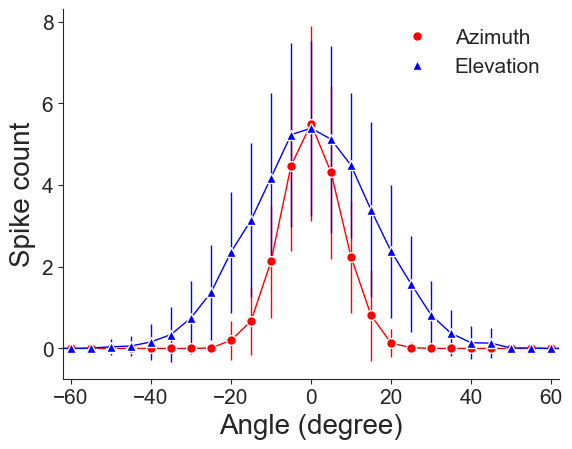

In [44]:

plt.plot(x, r_az, 'o', color='r', mec='w', ms=7)
plt.plot(x, r_el, '^', color='b', mec='w', ms=7)


plt.errorbar(x, r_az, s_az , color='r', fmt='o-', mec='w', elinewidth=1, lw=1, ms=7)
plt.errorbar(x, r_el, s_el, color='b', fmt='^-', mec='w', elinewidth=1, lw=1, ms=7)

plt.xlim(-62, 62)
sns.despine(right=True, top=True)

plt.xlabel('Angle (degree)', fontsize=20)
plt.ylabel('Spike count', fontsize=20)


plt.legend(['Azimuth', 'Elevation'], frameon=False, fontsize=15)

plt.show()

## Plot normalized responses

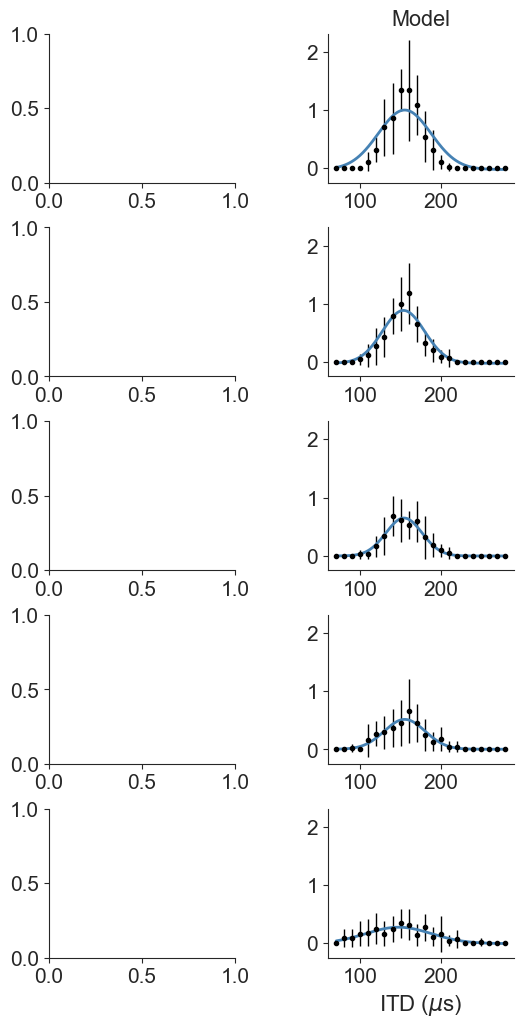

In [47]:
np.random.seed(4)

plt.subplots(5,2, figsize=(6,12))

ITD = np.arange(70, 290, 10)
number_trial = 10
best_itd = 155

BC = np.arange(100, 0, -20) / 100
number_bc = len(BC)


for n, bc in enumerate(BC):

    # Get the ITD curve for this neuron and BC
    mean_spike_count, std_spike_count = get_neuron_response_bc(bc, best_itd, w_bc1, ITD, number_trial)

    # Set the bounds and fit
    bounds=([ITD.min()-10, min_width, -0.1, -0.1], [ITD.max()+10, 250.0, np.max(mean_spike_count)*1.1, np.max(mean_spike_count)*1.25])

    best_parameters = fit_gaussian(ITD, mean_spike_count, bounds)
    
    if n == 0:
        NRM = best_parameters[2:].sum()
    
    
    # Reset the bound for gaussian sd
    min_width = 0.8*best_parameters[1]

    plt.subplot(5, 2, 2*(n+1))
    # Plot data
    plt.errorbar(ITD, mean_spike_count / NRM, std_spike_count / NRM, fmt='o', ecolor='k', color='k', elinewidth=1, ms=3)
    
    # Plot gaussian fit
    x = np.linspace(np.min(ITD), np.max(ITD), 1001, endpoint=True)
    model_curve = gaussian(x, *best_parameters) 
    plt.plot(x, model_curve / NRM, label='model', color='steelblue', lw=2)
    
    # Style
    if n == 0:
        y_max = np.max(mean_spike_count+std_spike_count)*1.05
        plt.title('Model')
    plt.ylim(-.25, y_max / NRM)
        
    
    if n == number_bc-1:
        plt.xlabel('ITD ($\mu$s)')

    sns.despine(right=True, top=True)




plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

plt.show()
